In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

2.9.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


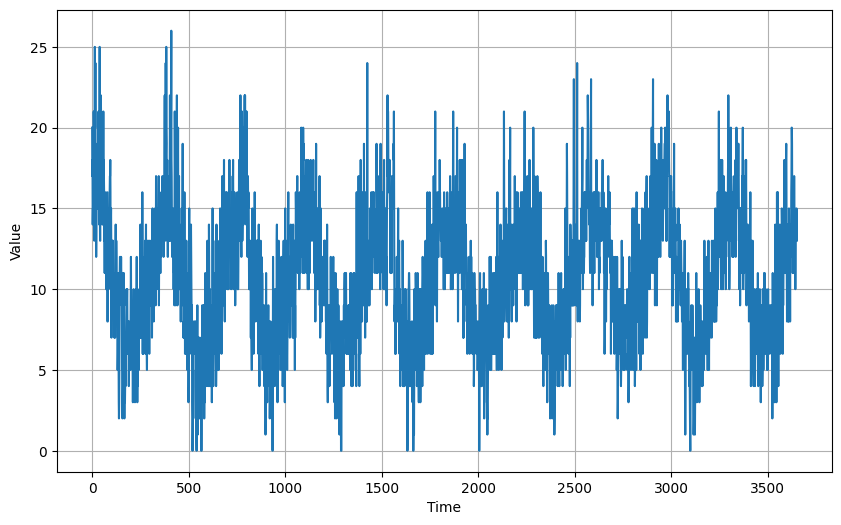

In [3]:
import csv
time_step = []
temps = []

with open('daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    # time_step.append(datetime.strptime(row[0], '%Y-%m-%d').timestamp())
    time_step.append(step)
    temps.append(int(float(row[1])))
    step += 1
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]# YOUR CODE HERE
x_train = series[:split_time]# YOUR CODE HERE
time_valid = time[split_time:]# YOUR CODE HERE
x_valid = series[split_time:]# YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # YOUR CODE HERE
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    
    results = np.array(forecast)[:, 0, 0]

    return results

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Dense(512, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
(2500,)
Epoch 1/100
10/10 [==============================] - 6s 373ms/step - loss: 11.6952 - mae: 12.1950 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 21ms/step - loss: 11.6879 - mae: 12.1877 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 21ms/step - loss: 11.6767 - mae: 12.1765 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 11.6631 - mae: 12.1629 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 20ms/step - loss: 11.6475 - mae: 12.1473 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 11.6299 - mae: 12.1297 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 25ms/step - loss: 11.6101 - mae: 12.1099 - lr: 1.9953e-08
Epoch 8/100
10/10 [=============================

(1e-08, 0.0001, 0.0, 60.0)

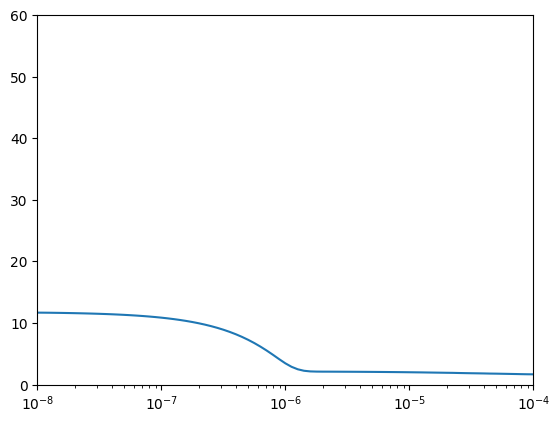

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
    tf.keras.layers.Dense(1024, input_shape=[60], activation="relu"),
    # tf.keras.layers.Dropout(.10), # Performance was better with no Dropout
    tf.keras.layers.Dense(512, activation="relu"),
    # tf.keras.layers.Dropout(.10), # Performance was better with no Dropout
    tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30)# YOUR CODE HERE)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/30
25/25 [==============================] - 1s 18ms/step - loss: 2.7549 - mae: 3.2188
Epoch 2/30
25/25 [==============================] - 1s 15ms/step - loss: 1.8787 - mae: 2.3299
Epoch 3/30
25/25 [==============================] - 0s 14ms/step - loss: 1.7524 - mae: 2.2026
Epoch 4/30
25/25 [==============================] - 1s 15ms/step - loss: 1.7064 - mae: 2.1558
Epoch 5/30
25/25 [==============================] - 0s 13ms/step - loss: 1.6635 - mae: 2.1110
Epoch 6/30
25/25 [==============================] - 1s 16ms/step - loss: 1.6219 - mae: 2.0680
Epoch 7/30
25/25 [==============================] - 1s 15ms/step - loss: 1.6038 - mae: 2.0501
Epoch 8/30
25/25 [==============================] - 0s 13ms/step - loss: 1.5855 - mae: 2.0302
Epoch 9/30
25/25 [==============================] - 0s 13ms/step - loss: 1.5633 - mae: 2.0092
Epoch 10/30
25/25 [==============================] - 0s 13ms/step - loss: 1.5648 - mae: 2.0117
Epoch 11/30
25/25 [==============================] - 0s 13m

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS